In [16]:
#import necessary libraries 
import numpy as np
import pyvisa
import matplotlib.pyplot as plt
from typing import Union, Literal, Callable

In [23]:
rm = pyvisa.ResourceManager('@py') # I use the py backend. change accordingly 

#if you have connected more serial instruments, this may not hold 
address = rm.list_resources()[-1]
print(address)
#and you can use the following to see all serial resources 
#print(rm.list_resources())

#You may need to give permission for read write in Linux
#open a terminal and execute the following command 
#sudo chmod 666 /dev/... 
#eg. sudo chmod 666 /dev/ttyACM3

ASRL/dev/ttyACM7::INSTR


In [143]:
class AWG:
    def __init__(self,address: str,rm: pyvisa.ResourceManager):
        self.address =  address
        self.rm = rm
        self.wave_type = None
        self.arb = None #(1,2,3,4) slots 
        self.waveform = None #waveform for arbitrary mode
        self.output = None #variable to control output "ON" OR "OFF"
        self.freq = None 
        self.amp = None #Vpp 
        self.offset = None
        self.channel = None
        self.inst = None
        self.connect() 
        

    def connect(self):
        print("Connecting...")
        self.inst = rm.open_resource(address)
        self.inst.read_termination = '\r\n'
        self.inst.write_termination = '\r\n'
        print("Connected to...")
        print(self.inst.query('*IDN?'))

    def set_wave(self, wave_type: Union[Literal['SINE', 'SQUARE', 'RAMP', 'PULSE', 'NOISE','ARB'], Callable] = 'SINE'):
        self.wave_type = wave_type
        self.inst.write('WAVE ' + self.wave_type)
        print(f'Wave type is now set to {self.wave_type}')
            
        
    def set_output(self, output):
        #only 'ON' and 'OFF' are valid keywords
        self.output = output
        self.inst.write("OUTPUT " + self.output)
        print("OUTPUT IS NOW " + self.output)

    def set_offset(self,offset): #volts
        self.offset = offset
        self.inst.write('DCOFFS '+ str(offset))
        
    def set_amplitude(self,amp): #volts
        self.amp = amp
        self.inst.write("AMPL "+ str(amp))

    def set_frequency(self,freq):
        self.freq = freq
        self.inst.write("FREQ " + str(freq))

    def set_channel(self,chn): #only one channel in TG5011A
        self.channel = chn
        self.inst.write("CHN "+ str(self.channel))

    def upload_arb_waveform(self,waveform,arb = 1):
        self.arb = arb
        self.waveform = waveform
        #Normalization of Waveform
        waveform_int = np.round(((waveform - np.min(waveform)) / (np.max(waveform) - np.min(waveform))) * (16383)).astype(np.uint16)
        waveform_bytes = waveform_int.astype(">u2").tobytes() # big-endian (>) unsigned 16-bit integer (u2).
        #for each point we have two bytes - so the number of bytes must be always twice the number of points
        data_length = len(waveform_bytes)
        header = f"#{len(str(data_length))}{data_length}".encode()
        arb_data = header + waveform_bytes
        self.inst.write_raw(b"ARB1 "+ arb_data) 
        self.inst.write("ARBLOAD ARB1")
        #fix scaling
        off = (np.max(waveform) + np.min(waveform))/4
        p2p = (np.max(waveform) - np.min(waveform))/2
        self.set_offset(off)
        self.set_amplitude(p2p)
        

    def misc_commands_write(self,command):
        self.inst.write(command)

    def misc_commands_query(self,command):
        print(self.inst.query(command))

In [144]:
awg = AWG(address, rm)

Connecting...
Connected to...
THURLBY THANDAR, TG5011A, 423426, 01.07-02.06-01.20


In [128]:
awg.set_wave("SINE")

Wave type is now set to SINE


In [124]:
awg.set_output("ON")

OUTPUT IS NOW ON


In [113]:
awg.set_offset(0)

In [114]:
awg.set_amplitude(1)

In [77]:
awg.set_frequency(3e4)

In [141]:
#create a test waveform
num_points = 1024  

waveform = -1*np.sin(np.linspace(0,24*np.pi,num_points))**2 + -2 + 4 * np.sin(2*np.pi*np.linspace(0,12*np.pi,num_points))

waveform[0:num_points//4] =  -3

In [145]:
awg.upload_arb_waveform(waveform)

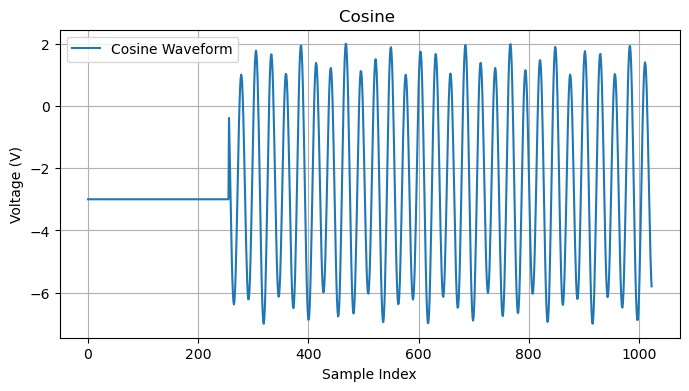

In [139]:
plt.figure(figsize=(8, 4))
plt.plot(waveform, label="Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Voltage (V)")
plt.title("Cosine ")
plt.grid()
plt.legend()
plt.show()
